In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!kaggle datasets download -d devbatrax/fracture-detection-using-x-ray-images

 98% 169M/172M [00:02<00:00, 92.4MB/s]
100% 172M/172M [00:02<00:00, 82.9MB/s]


In [ ]:
file_name = "/content/fracture-detection-using-x-ray-images.zip"

In [ ]:
import os
from zipfile import ZipFile
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from PIL import Image

In [ ]:
BATCH_SIZE = 80
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
val_dataset = dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names
print(len(dataset))

class_names = val_dataset.class_names
class_names
len(val_dataset)

8


8

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

for image_batch, labels_batch in val_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(80, 256, 256, 3)
[0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1
 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0
 1 0 0 0 1 0]
(80, 256, 256, 3)
[1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0
 1 1 0 1 0 1]


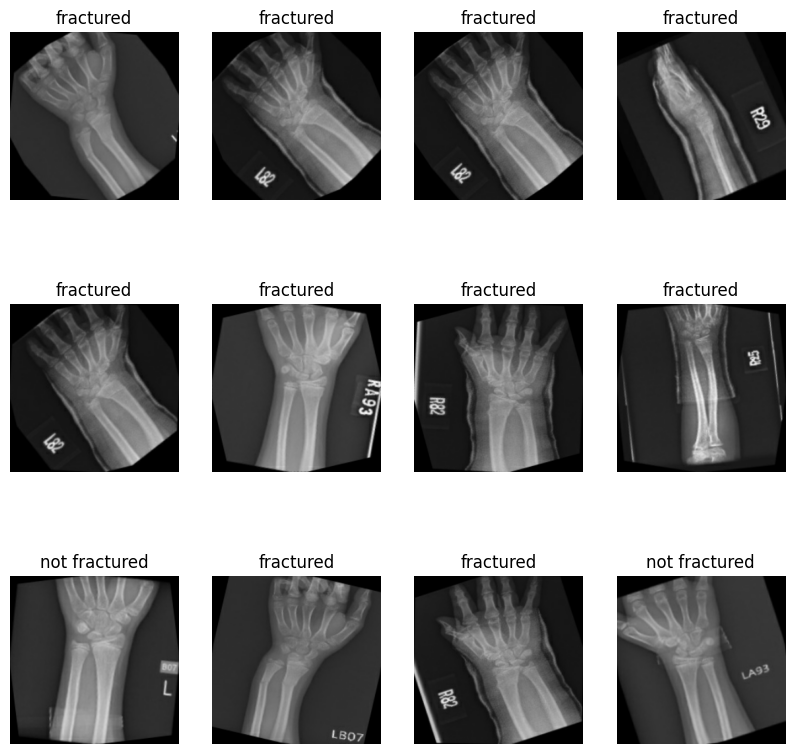

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)

    return train_ds,  test_ds

In [ ]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds) ,len(test_ds))
val_size = 0.1
val_len=round(len(val_dataset)*val_size)
val_ds = val_dataset.take(val_len)
len(val_ds)

6 2


1

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (80, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (80, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (80, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (80, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (80, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (80, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
6/6 [==============================] - 4s 761ms/step - loss: 0.2646 - accuracy: 0.8705 - val_loss: 0.2595 - val_accuracy: 0.8687
Epoch 2/30
6/6 [==============================] - 5s 735ms/step - loss: 0.2468 - accuracy: 0.8773 - val_loss: 0.2459 - val_accuracy: 0.8687
Epoch 3/30
6/6 [==============================] - 4s 668ms/step - loss: 0.2357 - accuracy: 0.8773 - val_loss: 0.2524 - val_accuracy: 0.8687
Epoch 4/30
6/6 [==============================] - 5s 844ms/step - loss: 0.2311 - accuracy: 0.8864 - val_loss: 0.2095 - val_accuracy: 0.8875
Epoch 5/30
6/6 [==============================] - 4s 674ms/step - loss: 0.2132 - accuracy: 0.8886 - val_loss: 0.2605 - val_accuracy: 0.8687
Epoch 6/30
6/6 [==============================] - 4s 669ms/step - loss: 0.2193 - accuracy: 0.8977 - val_loss: 0.2037 - val_accuracy: 0.8813
Epoch 7/30
6/6 [==============================] - 5s 764ms/step - loss: 0.2165 - accuracy: 0.8886 - val_loss: 0.1883 - val_accuracy: 0.9625
Epoch 8/30
6/6 [====

In [ ]:
scores = model.evaluate(val_ds)

1/1 [==============================] - 0s 69ms/step - loss: 1.4003e-04 - accuracy: 1.0000


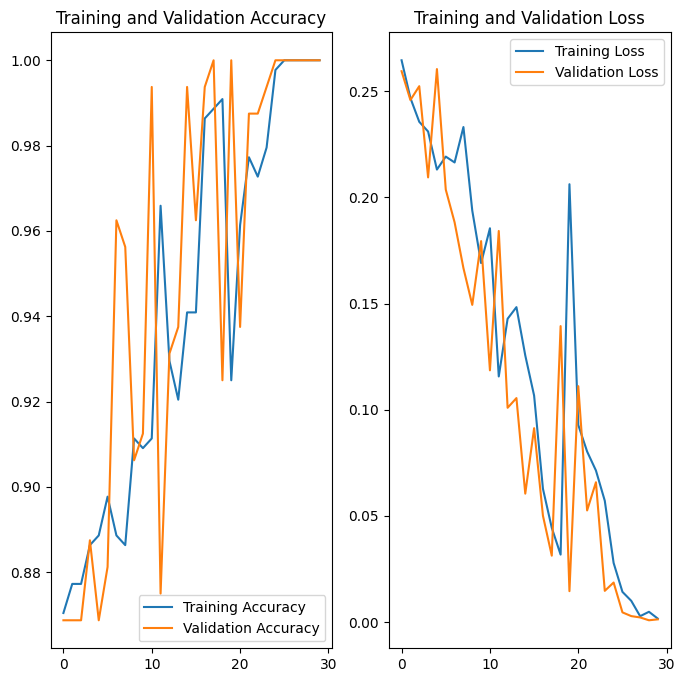

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: fractured
3/3 [==============================] - 0s 23ms/step
predicted label: fractured


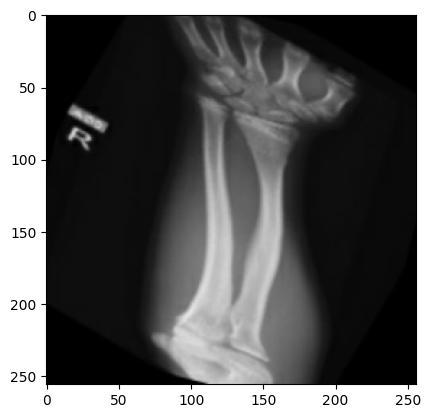

In [ ]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


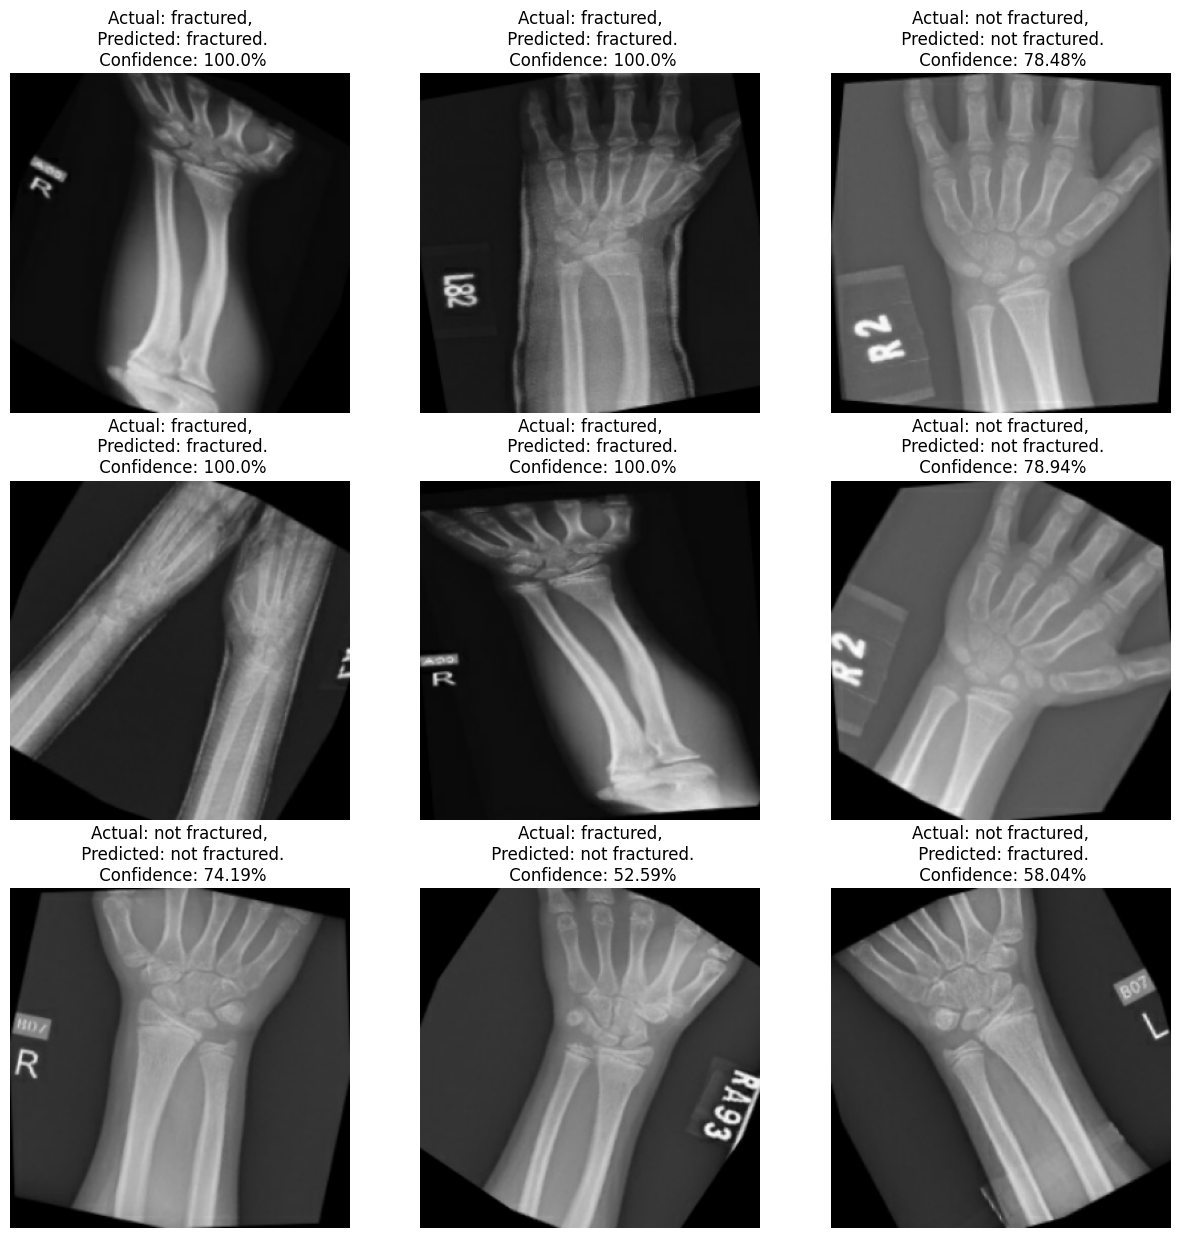

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("/content/data/models") + [0]])+1
model.save(f"/content/data/models/{model_version}")

In [ ]:
model.save("../fracture.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 10.5 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl si

In [ ]:
import gradio as gr

In [ ]:
def predict_image(img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    return {class_names[i]: float(predictions[0][i]) for i in range(2)}

In [ ]:
image = gr.Image(type='pil')
gr.Interface(fn=predict_image, inputs=image, outputs='label').launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://742a3c26b6ed7f5b97.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 40ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://742a3c26b6ed7f5b97.gradio.live
